# Settings

In [1]:
EXP_NO = 20
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'
REGRESSION = True

In [2]:
assert((TARGET, REGRESSION) in (('target', True), ('target', False), ('sorting_date', True)))

# Library

In [3]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.feature import hog
from skimage.color import rgb2hsv
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score
from sklearnex import patch_sklearn


SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from features import extract_representative_color_features, extract_representative_colors
from dataset import load_csvfiles, load_photofile
from folder import experiment_dir_of
from target import soring_date2target

In [4]:
pd.options.display.float_format = '{:.5f}'.format

In [5]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Prepare directory

In [6]:
output_dir = experiment_dir_of(EXP_NO)

In [7]:
output_dir

'..\\scripts\\..\\experiments\\exp020'

# Prepare logger

In [8]:
logger = getLogger(__name__)

In [9]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [10]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))

2021-07-21 19:36:10,626 - __main__ - INFO - Experiment no: 20
2021-07-21 19:36:10,627 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-21 19:36:10,628 - __main__ - INFO - SEED: 1
2021-07-21 19:36:10,629 - __main__ - INFO - REGRESSION: True


# Load csv files

In [11]:
SINCE = time.time()

In [12]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-21 19:36:10,655 - __main__ - DEBUG - Start loading csv files (0.017 seconds passed)
2021-07-21 19:36:10,678 - __main__ - DEBUG - Complete loading csv files (0.040 seconds passed)


In [13]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [14]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Feature engineering

## Extract representative colors

Refference:  
https://qiita.com/simonritchie/items/396112fb8a10702a3644

### Example: extract 5 representative colors

In [15]:
sample_object_id = train.sample(1)['object_id'].values[0]
sample_object_id

'02347217e42a82dd5d64'

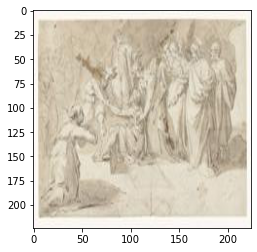

In [16]:
image = load_photofile(sample_object_id)
plt.imshow(image)

In [17]:
%%time
representitive_colors = extract_representative_colors(image, n_jobs=-1, num_colors=8, seed=SEED)
representitive_colors

C:\Users\nndropout\miniconda3\envs\atmacup11\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Wall time: 829 ms


array([151.50283861, 138.08678021, 116.81021898, 170.8596094 ,
       157.9459383 , 137.0478347 , 185.37556054, 172.62972454,
       151.52098014, 198.76422764, 186.37347561, 164.88998984,
       210.06748003, 198.30425394, 176.94580004, 219.41004184,
       210.326867  , 191.00748066, 228.17114137, 220.33426645,
       202.42231836, 251.36509704, 247.79080496, 242.21174038])

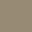

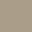

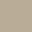

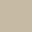

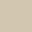

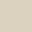

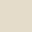

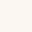

In [18]:
from PIL import Image
representitive_colors = representitive_colors.reshape(-1, 3).astype(int, copy=False)
for rgb_arr in representitive_colors:
    color_hex_str = '#%02x%02x%02x' % tuple(rgb_arr)
    color_img = Image.new(
        mode='RGB', size=(32, 32), color=color_hex_str)
    display(color_img)

In [19]:
import warnings

In [20]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    train_features = {object_id: extract_representative_color_features(object_id, seed=SEED, n_jobs=-1, num_colors=8)
                      for object_id in train['object_id']}

Wall time: 2h 16min 6s


In [21]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    X_test = np.array([extract_representative_color_features(object_id, seed=SEED, n_jobs=-1, num_colors=8)
                      for object_id in test['object_id']])

Wall time: 3h 27min 21s


# Cross validation

In [22]:
train.set_index('object_id', inplace=True)

In [23]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # Separate dataset into training/validation fold
    X_train = np.array([train_features[object_id] for object_id in train_object_ids])
    y_train = train.loc[train_object_ids, TARGET].values
    X_valid = np.array([train_features[object_id] for object_id in valid_object_ids])
    y_valid = train.loc[valid_object_ids, TARGET].values
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## train estimator
    estimator = SVR(C=10.0)
    estimator.fit(X_train, y_train)
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    
    # Save model and prediction
    ## Prediction
    if REGRESSION:
        pred_train = pd.DataFrame(data=estimator.predict(X_train), columns=['pred'])
        pred_valid = pd.DataFrame(data=estimator.predict(X_valid), columns=['pred'])
        pred_test = pd.DataFrame(data=estimator.predict(X_test), columns=['pred'])
    else:
        try:
            pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
                                     columns=estimator.classes_)
        except AttributeError:
            pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.decision_function(X_test),
                                     columns=estimator.classes_)
    ## Training set
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
    with open(filepath_fold_model, 'wb') as f:
        pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, X_train, X_valid, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

2021-07-22 01:19:40,748 - __main__ - DEBUG - Start fold 1 (20610.110 seconds passed)
2021-07-22 01:19:40,773 - __main__ - DEBUG - Start training model (20610.135 seconds passed)
2021-07-22 01:19:43,060 - __main__ - DEBUG - Complete training (20612.423 seconds passed)
2021-07-22 01:19:51,982 - __main__ - DEBUG - Save training fold to ..\scripts\..\experiments\exp020\cv_fold1_training.csv (20621.344 seconds passed)
2021-07-22 01:19:51,987 - __main__ - DEBUG - Save validation fold to ..\scripts\..\experiments\exp020\cv_fold1_validation.csv (20621.349 seconds passed)
2021-07-22 01:19:52,004 - __main__ - DEBUG - Save test result ..\scripts\..\experiments\exp020\cv_fold1_test.csv (20621.366 seconds passed)
2021-07-22 01:19:52,014 - __main__ - DEBUG - Save model ..\scripts\..\experiments\exp020\cv_fold1_model.pkl (20621.376 seconds passed)
2021-07-22 01:19:52,236 - __main__ - DEBUG - Complete fold 1 (20621.598 seconds passed)
2021-07-22 01:19:52,237 - __main__ - DEBUG - Start fold 2 (20621.59

# Evaluation

In [24]:
rmse = partial(mean_squared_error, squared=False)

In [25]:
# qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [26]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [27]:
metrics = defaultdict(list)

## Training set

In [28]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_train_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_train_df['pred'] = np.vectorize(soring_date2target)(pred_train_df['pred'])
            pred_train_df['actual'] = np.vectorize(soring_date2target)(pred_train_df['actual'])
    else:
        pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                        pred_train_df['2'], pred_train_df['3'])
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
#     score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
#     metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
# metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
# metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-22 01:20:37,048 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-22 01:20:37,063 - __main__ - DEBUG - Loss: 0.6559200730444071
2021-07-22 01:20:37,064 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-22 01:20:37,077 - __main__ - DEBUG - Loss: 0.6386197475159422
2021-07-22 01:20:37,078 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-22 01:20:37,091 - __main__ - DEBUG - Loss: 0.6504573540164685
2021-07-22 01:20:37,091 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-22 01:20:37,104 - __main__ - DEBUG - Loss: 0.6420628932287621
2021-07-22 01:20:37,105 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-22 01:20:37,118 - __main__ - DEBUG - Loss: 0.6526939756402065


In [29]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
if not REGRESSION:
    pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_train['actual'] = np.vectorize(soring_date2target)(pred_train['actual'])
# for c in ('pred', 'actual'):
#     pred_train[c] = pred_train[c].astype('int')
pred_train

,pred,actual
object_id,,
002bff09b09998d0be65,1.17321,1
00309fb1ef05416f9c1f,2.38002,3
003a1562e97f79ba96dc,2.32518,3
004890880e8e7431147b,0.84172,2
00718c32602425f504c1,2.31994,3
...,...,...
ffa3259fff8e6f3818a1,2.14527,3
ffd4d361756587883e48,1.08791,1
ffd794b7b311b7b7fd92,1.68001,2


In [30]:
if not (REGRESSION and TARGET == 'target'):
    print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
# score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
# metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
# logger.info('Training score: {}'.format(score))

2021-07-22 01:20:37,186 - __main__ - INFO - Training loss: 0.7395504178327841


In [31]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-22 01:20:37,213 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp020\prediction_train.csv


## Validation set

In [32]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_valid_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_valid_df['pred'] = np.vectorize(soring_date2target)(pred_valid_df['pred'])
            pred_valid_df['actual'] = np.vectorize(soring_date2target)(pred_valid_df['actual'])
    else:
        pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                        pred_valid_df['2'], pred_valid_df['3'])        
    
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
#     score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
#     metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
# metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
# metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-22 01:20:37,235 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-22 01:20:37,250 - __main__ - DEBUG - Loss: 0.8177676241818103
2021-07-22 01:20:37,251 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-22 01:20:37,263 - __main__ - DEBUG - Loss: 0.8690084017023342
2021-07-22 01:20:37,264 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-22 01:20:37,275 - __main__ - DEBUG - Loss: 0.8316098785293601
2021-07-22 01:20:37,276 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-22 01:20:37,287 - __main__ - DEBUG - Loss: 0.8630016664958585
2021-07-22 01:20:37,287 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-22 01:20:37,298 - __main__ - DEBUG - Loss: 0.8338738268955338


In [33]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
if not REGRESSION:
    pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_valid['actual'] = np.vectorize(soring_date2target)(pred_valid['actual'])
# for c in ('pred', 'actual'):
#     pred_valid[c] = pred_valid[c].astype('int')
pred_valid

,pred,actual
object_id,,
002bff09b09998d0be65,0.30754,1
00309fb1ef05416f9c1f,0.60000,3
003a1562e97f79ba96dc,0.54862,3
004890880e8e7431147b,0.15862,2
00718c32602425f504c1,0.55454,3
...,...,...
ffa3259fff8e6f3818a1,0.44896,3
ffd4d361756587883e48,0.24465,1
ffd794b7b311b7b7fd92,0.60000,2


In [34]:
if not REGRESSION:
    print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
# score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
# metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
# logger.info('Validatino score: {}'.format(score))

2021-07-22 01:20:37,342 - __main__ - INFO - Validatino loss: 1.6956907711910478


In [35]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-22 01:20:37,366 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp020\prediction_valid.csv


In [36]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-22 01:20:37,373 - __main__ - DEBUG - Write metrics to ..\scripts\..\experiments\exp020\metrics.json


# Prediction

In [37]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [38]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
if REGRESSION:
    if TARGET == 'target':
        pred_test['pred'].clip(lower=0, upper=3, inplace=True)
    else:
        pred_test['pred'] = np.vectorize(soring_date2target)(pred_test['pred'])
else:
    pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,pred
object_id,
0009e50b94be36ccad39,1.19447
000bd5e82eb22f199f44,2.36135
0015f44de1854f617516,1.23330
00388a678879ba1efa27,1.87745
005e1e7c6496902d23f3,0.96986
...,...
ffbe65ad399b632dcbd0,2.15393
ffd7b2d646c0320c311a,0.99894
ffdb93ede17d4501e530,2.14517


In [39]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,1.19447
1,2.36135
2,1.23330
3,1.87745
4,0.96986
...,...
5914,2.15393
5915,0.99894
5916,2.14517
5917,1.96117


In [40]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [41]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-22 01:20:37,541 - __main__ - DEBUG - Write submission to ..\scripts\..\experiments\exp020\020_submission.csv


2021-07-22 01:20:37,653 - __main__ - DEBUG - Write figure to ..\scripts\..\experiments\exp020\prediction.png


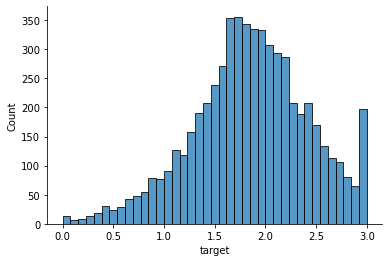

In [42]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [43]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-22 01:20:37,753 - __main__ - DEBUG - Complete (20667.115 seconds passed)


In [44]:
%%time
with open(os.path.join(output_dir, 'train_features.pkl'), 'wb') as f:
    pickle.dump(train_features, f)

Wall time: 27 ms


In [45]:
%%time
with open(os.path.join(output_dir, 'test_features.pkl'), 'wb') as f:
    pickle.dump(X_test, f)

Wall time: 16 ms
